In [6]:
import pandas as pd
import os
import openpyxl
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm, chi2
import matplotlib.pyplot as plt

In [154]:
import pyfolio as pf
from scipy.stats import binom
import math
import numpy.matlib as mt

In [8]:
# Get the current working directory
# current_working_directory = os.getcwd()
# # Load the Excel file
# file_path = '/Users/minhanhle/Documents/MasterArbeit/Eurostoxx1.xlsx'
# sheet_name = 'Tabelle1'
# # Read the Excel file and skip the first 3 rows and row 5 (row 4 after skipping 3)
# df = pd.read_excel(file_path, sheet_name=sheet_name, skiprows=[0, 1, 2, 4])
# df.head(3)

In [9]:
# # Remove any columns with missing values
# df = df.dropna(axis=1)
# # Convert the first column to datetime format and set it as the index
# df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])
# df.set_index(df.columns[0], inplace=True)
# # Filter the data to include only dates between 01.01.2018 and 01.01.2024
# start_date = '2018-01-01'
# end_date = '2024-01-01'
# df = df[(df.index >= start_date) & (df.index <= end_date)]
# # Define the public holidays in Germany from 2018 to 2024
# holidays = [
#     '2018-01-01', '2018-03-30', '2018-04-02', '2018-05-10', '2018-05-21', '2018-10-03', '2018-12-24', '2018-12-25', '2018-12-26', '2018-12-31',
#     '2019-01-01', '2019-04-19', '2019-04-22', '2019-05-30', '2019-06-10', '2019-10-03', '2019-12-24', '2019-12-25', '2019-12-26', '2019-12-31',
#     '2020-01-01', '2020-04-10', '2020-04-13', '2020-05-21', '2020-06-01', '2020-10-03', '2020-12-24', '2020-12-25', '2020-12-26', '2020-12-31',
#     '2021-01-01', '2021-04-02', '2021-04-05', '2021-05-13', '2021-05-24', '2021-10-03', '2021-12-24', '2021-12-25', '2021-12-26', '2021-12-31',
#     '2022-01-01', '2022-04-15', '2022-04-18', '2022-05-26', '2022-06-06', '2022-10-03', '2022-12-24', '2022-12-25', '2022-12-26', '2022-12-31',
#     '2023-01-01', '2023-04-07', '2023-04-10', '2023-05-18', '2023-05-29', '2023-10-03', '2023-12-24', '2023-12-25', '2023-12-26', '2023-12-31',
#     '2024-01-01'
# ]

# # Convert holidays to datetime format and remove them from the DataFrame
# holidays = pd.to_datetime(holidays)
# df = df[~df.index.isin(holidays)]

# Save the cleaned data to a CSV file without row numbers
# output_path = '/Users/minhanhle/Documents/MasterArbeit/MasterArbeitCode/Cleaned_Eurostoxx.csv'
# df.to_csv(output_path, index=True)

In [10]:
df = pd.read_csv('./Cleaned_Eurostoxx.csv')
df.rename(columns={'Name': 'Datum'}, inplace=True)
df.columns = [col.replace(' (~E )', '') for col in df.columns]
df.set_index('Datum', inplace=True)
df.head(5)

,3I GROUP,A P MOLLER MAERSK B,A2A,AAK,AALBERTS,ABB LTD N,ABN AMRO BANK,ABRDN,ACCIONA,ACCOR,...,WHITBREAD,WIENERBERGER,WIHLBORGS FASTIGHETER,WOLTERS KLUWER,WORLDLINE,WPP,YARA INTERNATIONAL,ZALANDO (XET),ZEALAND PHARMA,ZURICH INSURANCE GROUP
Datum,,,,,,,,,,,,,,,,,,,,,
2018-01-02,10.36,1235.13,1.522,11.74,42.29,21.526,26.84,4.76,68.46,43.48,...,38.45,20.56,4.97,43.46,40.64,15.07,38.67,43.95,11.90,253.275
2018-01-03,10.37,1228.24,1.516,11.79,42.80,21.714,26.81,4.71,68.80,43.31,...,38.37,20.74,5.03,43.70,41.14,14.64,39.22,45.19,12.34,252.397
2018-01-04,10.48,1264.70,1.570,11.97,43.51,21.909,27.06,4.77,70.40,43.60,...,38.57,21.08,5.02,44.07,41.98,14.80,39.10,45.10,12.54,253.429
2018-01-05,10.63,1273.07,1.593,12.13,44.13,22.131,27.23,4.78,71.14,43.77,...,38.67,20.82,5.04,44.55,41.78,15.09,39.77,45.14,12.32,255.630
2018-01-08,10.43,1307.33,1.591,12.18,44.33,22.227,27.42,4.86,71.06,44.38,...,38.54,20.90,5.12,44.50,42.36,15.07,40.66,45.31,12.35,257.668


In [113]:
# Berechnung der täglichen Rendite
returns = np.log(df/ df.shift(1))
returns.index = df.index
returns.shape

(1517, 564)

In [121]:
# Drop NA
returns = returns.dropna()
#Definiere Gewichte 
gewicht = 1/len(df.columns)

#Definiere Sample/Test Set
sampleSize = len(returns)
windowSize = 250
testWindowSize = sampleSize-windowSize
print(testWindowSize)
V = df[windowSize:len(df)]*gewicht

1266


In [125]:
print(V)

            3I GROUP  A P MOLLER MAERSK B       A2A       AAK  AALBERTS  \
Datum                                                                     
2018-12-28  0.015638             1.630035  0.002788  0.021188  0.050230   
2019-01-02  0.015426             1.652057  0.002843  0.021365  0.050337   
2019-01-03  0.015177             1.624167  0.002848  0.021152  0.048794   
2019-01-04  0.015904             1.710957  0.002891  0.021560  0.051082   
2019-01-07  0.015851             1.734876  0.002895  0.021507  0.051099   
...              ...                  ...       ...       ...       ...   
2023-12-21  0.049344             2.846560  0.003301  0.035940  0.069681   
2023-12-22  0.049557             2.925656  0.003296  0.036206  0.070089   
2023-12-27  0.049858             2.789592  0.003280  0.036117  0.070053   
2023-12-28  0.049681             2.742145  0.003286  0.036365  0.069716   
2023-12-29  0.049539             2.778387  0.003296  0.035798  0.069610   

            ABB LTD N  A

In [116]:
returns.shape

(1516, 564)

In [159]:
#VaR Konfidenzniveau
pVaR = 0.999
#Get Zscores for alpha value
zScore = norm.ppf(pVaR)

#Definiere VaR-Vektoren
normalVaR = np.zeros(testWindowSize)
shrinkageVaR = np.zeros(testWindowSize)

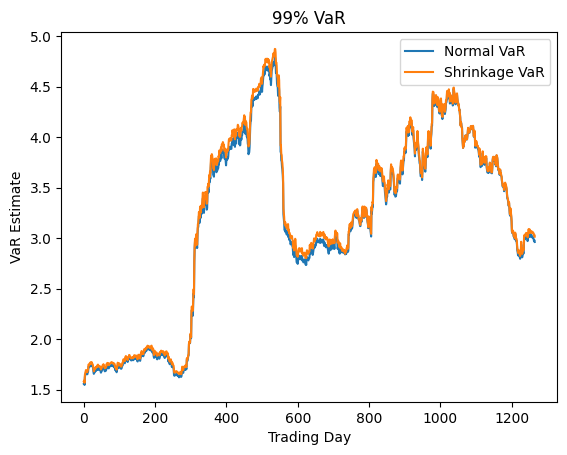

In [171]:
normalPortfolioSigmas = pd.DataFrame()
normalVaR = pd.DataFrame()
shrinkageVaR = pd.DataFrame()
portfolioGewinnVerlust = pd.DataFrame()
for t in range(testWindowSize):
    k = windowSize + t

    # Berechnen der Kovarianzmatrix
    df_test = df[t:k]
    returnsData = returns[t:k].reset_index(drop=True)
    covMatrix = np.cov(returnsData, rowvar=False)
    shrinkage_cov = covCor(returnsData)
    #print(shrinkage_cov.shape)
    # Berechnen der Standardabweichung der Portfolio-Renditen
    v = V.iloc[t, :].reset_index(drop=True)
    v_trans = v.T
    # Berechne Stichproben-VKM sigma 
    sigma = np.sqrt(v_trans@covMatrix@v)
    normalPortfolioSigmas.loc[t,'Sigma'] = sigma
    # Berechne Shrinkage-VKA
    sigmahat = np.sqrt(v_trans@shrinkage_cov@v)
    #print(sigmahat.shape)
    # Speichern der VaR-Werte mit normalen VKM
    normalVaR.loc[t,'GV'] = zScore * sigma
    # Speichern der VaR-Werte mit Shrinkage-VKM
    shrinkageVaR.loc[t,'GV'] = zScore * sigmahat
    # Speichern der Gewinn-Verlust-Werte
    portfolioGewinnVerlust.loc[t,'GV'] = np.sum(returns.iloc[k, :] * v)

#Plotten der VaR-Werte
plt.plot()
plt.plot(range(0, testWindowSize), normalVaR, label='Normal VaR')
plt.plot(range(0, testWindowSize), shrinkageVaR, label='Shrinkage VaR')
plt.xlabel('Trading Day')
plt.ylabel('VaR Estimate')
plt.title('99% VaR')
plt.legend()
plt.show()
#TODO: x-Achse die Datum angezeigen werden.

In [129]:
returns_testWindow = returns.iloc[250:]
returns_testWindow.head(3)

,3I GROUP,A P MOLLER MAERSK B,A2A,AAK,AALBERTS,ABB LTD N,ABN AMRO BANK,ABRDN,ACCIONA,ACCOR,...,WHITBREAD,WIENERBERGER,WIHLBORGS FASTIGHETER,WOLTERS KLUWER,WORLDLINE,WPP,YARA INTERNATIONAL,ZALANDO (XET),ZEALAND PHARMA,ZURICH INSURANCE GROUP
Datum,,,,,,,,,,,,,,,,,,,,,
2019-01-02,-0.013699,0.013419,0.019522,0.008333,0.002116,0.003052,0.007824,0.003478,0.035378,0.004381,...,0.011232,0.021979,0.006006,-0.001171,0.000481,-0.003176,0.004482,0.022908,0.008126,0.002999
2019-01-03,-0.016223,-0.017026,0.001869,-0.010008,-0.031124,-0.016430,0.008246,-0.031749,0.020379,-0.016529,...,-0.006862,-0.016439,-0.001998,-0.018530,-0.065019,-0.011733,-0.002986,0.043049,0.015172,-0.004644
2019-01-04,0.046785,0.052058,0.014829,0.019096,0.045810,0.026763,0.029512,0.045542,0.003661,0.023065,...,0.028509,0.030470,0.019803,0.018530,0.017790,0.020181,0.080411,0.032426,0.033961,0.016159


In [17]:
# # Plotten der Daten
# plt.figure(figsize=(10, 6))
# plt.plot(returns_testWindow.index, returns_testWindow.iloc[:, 0])  # Plot der ersten Spalte als Beispiel
# plt.xlabel('Date')
# plt.ylabel('Asset Return')
# plt.title('Asset Returns over Time')

# # Datumswerte auf der x-Achse um 90 Grad drehen
# plt.xticks(rotation=60)

# # Plot anzeigen
# plt.tight_layout()  # Um sicherzustellen, dass die Labels nicht abgeschnitten werden
# plt.show()

***Backtesting***

In [138]:
def UCoverage(PuL,VaR,P):
    Compare = pd.concat([PuL,-VaR],axis=1)
    Number_of_Fail=len(Compare.loc[Compare.T.iloc[0]<Compare.T.iloc[1]])
    N = Number_of_Fail
    T = len(Compare)
    t = (1-N/T)**(T-N)*(N/T)**N
    c = ((P)**(T-N))*((1-P)**N)
    Ratio = 2*np.log(t)-2*np.log(c)
    p_value = chi2.sf(Ratio, df=1)
    return p_value

In [139]:
UCoverage(portfolioGewinnVerlust,normalVaR,0.95)

7.0455553982529355e-12

In [33]:
normalVaR.isnull().sum()
returns_test = returns[250:].reset_index(drop=True)
Compare = pd.concat([returns_test,-normalVaR],axis=1)
print(Compare.head(3))

   3I GROUP  A P MOLLER MAERSK B       A2A       AAK  AALBERTS  ABB LTD N  \
0 -0.013699             0.013419  0.019522  0.008333  0.002116   0.003052   
1 -0.016223            -0.017026  0.001869 -0.010008 -0.031124  -0.016430   
2  0.046785             0.052058  0.014829  0.019096  0.045810   0.026763   

   ABN AMRO BANK     ABRDN   ACCIONA     ACCOR  ...  WIENERBERGER  \
0       0.007824  0.003478  0.035378  0.004381  ...      0.021979   
1       0.008246 -0.031749  0.020379 -0.016529  ...     -0.016439   
2       0.029512  0.045542  0.003661  0.023065  ...      0.030470   

   WIHLBORGS FASTIGHETER  WOLTERS KLUWER  WORLDLINE       WPP  \
0               0.006006       -0.001171   0.000481 -0.003176   
1              -0.001998       -0.018530  -0.065019 -0.011733   
2               0.019803        0.018530   0.017790  0.020181   

   YARA INTERNATIONAL  ZALANDO (XET)  ZEALAND PHARMA  ZURICH INSURANCE GROUP  \
0            0.004482       0.022908        0.008126                0.002

###Shrinkage + CCM

In [157]:
def covCor(Y,k = None):
    
    #Pre-Conditions: Y is a valid pd.dataframe and optional arg- k which can be
    #    None, np.nan or int
    #Post-Condition: Sigmahat dataframe is returned
    
    # de-mean returns if required
    N,p = Y.shape                      # sample size and matrix dimension
   
   
    #default setting
    if k is None or math.isnan(k):
        
        mean = Y.mean(axis=0)
        Y = Y.sub(mean, axis=1)                               #demean
        k = 1

    #vars
    n = N-k                                    # adjust effective sample size

    #Cov df: sample covariance matrix
    sample = pd.DataFrame(np.matmul(Y.T.to_numpy(),Y.to_numpy()))/n     
        
    # compute shrinkage target
    samplevar = np.diag(sample.to_numpy())
    sqrtvar = pd.DataFrame(np.sqrt(samplevar))
    rBar = (np.sum(np.sum(sample.to_numpy()/np.matmul(sqrtvar.to_numpy(),sqrtvar.T.to_numpy())))-p)/(p*(p-1)) # mean correlation
    target = pd.DataFrame(rBar*np.matmul(sqrtvar.to_numpy(),sqrtvar.T.to_numpy()))
    target[np.logical_and(np.eye(p),np.eye(p))] = sample[np.logical_and(np.eye(p),np.eye(p))];
    
    # estimate the parameter that we call pi in Ledoit and Wolf (2003, JEF)
    Y2 = pd.DataFrame(np.multiply(Y.to_numpy(),Y.to_numpy()))
    sample2= pd.DataFrame(np.matmul(Y2.T.to_numpy(),Y2.to_numpy()))/n     # sample covariance matrix of squared returns
    piMat=pd.DataFrame(sample2.to_numpy()-np.multiply(sample.to_numpy(),sample.to_numpy()))
    pihat = sum(piMat.sum())
    
    # estimate the parameter that we call gamma in Ledoit and Wolf (2003, JEF)
    gammahat = np.linalg.norm(sample.to_numpy()-target,ord = 'fro')**2
    
    # diagonal part of the parameter that we call rho 
    rho_diag =  np.sum(np.diag(piMat))
    
    # off-diagonal part of the parameter that we call rho 
    term1 = pd.DataFrame(np.matmul((Y**3).T.to_numpy(),Y.to_numpy())/n)
    term2 = pd.DataFrame(np.transpose(mt.repmat(samplevar,p,1))*sample)
    thetaMat = term1-term2
    thetaMat[np.logical_and(np.eye(p),np.eye(p))] = pd.DataFrame(np.zeros((p,p)))[np.logical_and(np.eye(p),np.eye(p))]
    rho_off = rBar*(np.matmul((1/sqrtvar).to_numpy(),sqrtvar.T.to_numpy())*thetaMat).sum().sum()
    
    # compute shrinkage intensity
    rhohat = rho_diag + rho_off
    kappahat = (pihat - rhohat) / gammahat
    shrinkage = max(0 , min(1 , kappahat/n))
    
    # compute shrinkage estimator
    sigmahat = shrinkage*target + (1-shrinkage) * sample;
    
    return sigmahat



In [147]:
returns_sh = returns.iloc[250:len(returns)]



In [155]:
sigmahat = covCor(returns_test)
print(sigmahat)

          0         1         2         3         4         5         6    \
0    0.000443  0.000201  0.000158  0.000149  0.000277  0.000181  0.000234   
1    0.000201  0.000680  0.000117  0.000120  0.000236  0.000171  0.000202   
2    0.000158  0.000117  0.000300  0.000117  0.000165  0.000114  0.000170   
3    0.000149  0.000120  0.000117  0.000301  0.000157  0.000122  0.000128   
4    0.000277  0.000236  0.000165  0.000157  0.000497  0.000217  0.000296   
..        ...       ...       ...       ...       ...       ...       ...   
559  0.000275  0.000196  0.000150  0.000146  0.000286  0.000178  0.000294   
560  0.000158  0.000158  0.000120  0.000122  0.000194  0.000141  0.000185   
561  0.000225  0.000212  0.000154  0.000174  0.000284  0.000179  0.000190   
562  0.000153  0.000139  0.000134  0.000148  0.000145  0.000120  0.000113   
563  0.000157  0.000110  0.000113  0.000095  0.000145  0.000121  0.000187   

          7         8         9    ...       554       555       556  \
0  